In [1]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
import src.util as util
import yaml
import copy
from tqdm import tqdm
import os
from datetime import datetime
import openpyxl
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from collections import defaultdict

/Users/Geethika/Documents/GitHub/Medicare Claims/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
config_data=util.config_load()

In [3]:
df_simil_in=util.pickle_load(config_data['raw_dataset_path_data_simil'])
# df_ICD_embeddings=util.pickle_load(config_data['raw_dataset_path_ICD_embeddings_combined'])
# df_DRG_embeddings=util.pickle_load(config_data['raw_dataset_path_DRG_embeddings'])
# df_PRC_embeddings=util.pickle_load(config_data['raw_dataset_path_PROC_embeddings'])

In [4]:
df_simil_in.columns

Index(['Provider', 'Is_admit', 'ClmAdmitDiagnosisCode', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3'],
      dtype='object')

In [5]:
df_simil_diag_count=df_simil_in.copy()

In [6]:
def pad_code(code):
    if pd.isna(code):
        return code  # Keep NaN as is
    return str(code).zfill(4)  # Pad with zeros to make it 4 characters



In [7]:
for i in [ 'ClmAdmitDiagnosisCode', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3']:
    df_simil_in[i].astype(str)
    df_simil_in[i].replace(r'\.0$', '', regex=True,inplace=True)
    df_simil_in[i].replace(r'nan', np.nan, regex=True,inplace=True)
    df_simil_in[i]=df_simil_in[i].apply(pad_code)

/var/folders/nd/f34czdrj02175j4j_k03vfyw0000gp/T/ipykernel_1492/1800943709.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_simil_in[i].replace(r'\.0$', '', regex=True,inplace=True)
/var/folders/nd/f34czdrj02175j4j_k03vfyw0000gp/T/ipykernel_1492/1800943709.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting v

In [10]:


# Sample DataFrame structure (you would replace this with your actual DataFrame)


df = df_simil_in[['Provider',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10']]

# Step 1: Create a mapping from ICD codes to sets of providers
icd_to_providers = defaultdict(set)

# Combine diagnosis code columns and fill the mapping
diagnosis_columns = [f'ClmDiagnosisCode_{i}' for i in range(1, 11)]

for _, row in df.iterrows():
    Provider=row['Provider']
    for col in diagnosis_columns:
        icd_code = row[col]
        if pd.notna(icd_code):  # Check if the ICD code is not NaN
            icd_to_providers[icd_code].add(Provider)

# Step 2: Get unique ICD codes
icd_codes = list(icd_to_providers.keys())
m = len(icd_codes)

# Step 3: Initialize the Jaccard similarity matrix
jaccard_matrix = np.zeros((m, m))

# Function to calculate Jaccard similarity
def jaccard_similarity(set_a, set_b):
    intersection = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    return intersection / union if union != 0 else 0

# Step 4: Populate the Jaccard similarity matrix
for i in range(m):
    for j in range(m):
        if i == j:
            jaccard_matrix[i, j] = 1  # Jaccard similarity with itself is 1
        elif j > i:  # Calculate only for upper triangle to avoid redundancy
            similarity = jaccard_similarity(icd_to_providers[icd_codes[i]], icd_to_providers[icd_codes[j]])
            jaccard_matrix[i, j] = similarity
            jaccard_matrix[j, i] = similarity  # Symmetric matrix

# Step 5: Create a DataFrame for the Jaccard similarity matrix
jaccard_df = pd.DataFrame(jaccard_matrix, index=icd_codes, columns=icd_codes)


In [11]:
jaccard_df

,79678,71656,64881,36401,V4569,2948,4019,2989,78054,2875,...,1318,36460,0998,80606,79679,00321,80199,9792,9671,90182
79678,1.000000,0.043668,0.010989,0.005435,0.036885,0.069959,0.037810,0.092883,0.044355,0.086444,...,0.0,0.0,0.005587,0.0,0.0,0.0,0.005587,0.0,0.0,0.0
71656,0.043668,1.000000,0.000000,0.000000,0.055118,0.024021,0.013052,0.036891,0.029412,0.033508,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
64881,0.010989,0.000000,1.000000,0.000000,0.025974,0.002630,0.001088,0.006878,0.011905,0.004310,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
36401,0.005435,0.000000,0.000000,1.000000,0.012658,0.002629,0.001305,0.005487,0.011765,0.005388,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
V4569,0.036885,0.055118,0.025974,0.012658,1.000000,0.033490,0.016097,0.049803,0.062069,0.048168,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00321,0.000000,0.000000,0.000000,0.000000,0.000000,0.000526,0.000218,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0,0.0
80199,0.005587,0.000000,0.000000,0.000000,0.000000,0.000526,0.000218,0.001376,0.000000,0.001079,...,0.0,0.0,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0
9792,0.000000,0.000000,0.000000,0.000000,0.000000,0.000526,0.000218,0.000000,0.000000,0.001079,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.0,0.0,0.0
9671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000218,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0,0.0


In [13]:
df_similarity=jaccard_df.copy()

In [14]:
df_similarity.fillna(0,inplace=True)

In [15]:
df_group_data_diag_simil=pd.DataFrame(df_simil_in['Provider'].unique(),columns=['Provider'])
for i in [
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10']:
    pivot_data = df_simil_in[['Provider',i]].pivot_table(
    index='Provider',                      # Set 'Provider' as the index
    columns=[i],      # Set diagnosis codes as columns
    values=[i],       # Values to aggregate
    aggfunc={i:'count'},                       # Count occurrences
    fill_value=0                           # Fill missing values with 0
).reset_index() 
    pivot_data.columns = ['_'.join(map(str, col)) for col in pivot_data.columns.values]
    pivot_data.rename(columns={'Provider_':'Provider'},inplace=True)
    df_group_data_diag_simil=df_group_data_diag_simil.merge(pivot_data,on='Provider',how='left')
    

In [16]:
df_group_data_diag_simil

,Provider,ClmDiagnosisCode_1_0010,ClmDiagnosisCode_1_0011,ClmDiagnosisCode_1_0019,ClmDiagnosisCode_1_0020,ClmDiagnosisCode_1_0021,ClmDiagnosisCode_1_0022,ClmDiagnosisCode_1_0023,ClmDiagnosisCode_1_0024,ClmDiagnosisCode_1_0025,...,ClmDiagnosisCode_10_V7284,ClmDiagnosisCode_10_V741,ClmDiagnosisCode_10_V7651,ClmDiagnosisCode_10_V850,ClmDiagnosisCode_10_V851,ClmDiagnosisCode_10_V8531,ClmDiagnosisCode_10_V8533,ClmDiagnosisCode_10_V854,ClmDiagnosisCode_10_V860,ClmDiagnosisCode_10_V8801
0,PRV57172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,PRV55158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,PRV54966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,PRV54890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,PRV52145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV54294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5406,PRV51053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5407,PRV55405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5408,PRV57061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_group_data_diag_simil.columns = df_group_data_diag_simil.columns.str.split('_').str[-1]
df_group_data_diag_simil=df_group_data_diag_simil.T.groupby(df_group_data_diag_simil.columns).sum()
df_group_data_diag_simil=df_group_data_diag_simil.T
data_reordered=df_group_data_diag_simil[df_similarity.index]


In [18]:
data_reordered=df_group_data_diag_simil[df_similarity.index]

In [19]:
data_reordered

,79678,71656,64881,36401,V4569,2948,4019,2989,78054,2875,...,1318,36460,0998,80606,79679,00321,80199,9792,9671,90182
0,1.0,1.0,0.0,0.0,0.0,9.0,246.0,4.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,11.0,85.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,13.0,234.0,1.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,15.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,32.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5408,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
util.pickle_dump(df_group_data_diag_simil['Provider'],config_data['raw_dataset_provider_data'])
util.pickle_dump(data_reordered,config_data['raw_dataset_path_usage'])
util.pickle_dump(df_similarity,config_data['raw_dataset_path_simil_sub'])

In [21]:
df_similarity

,79678,71656,64881,36401,V4569,2948,4019,2989,78054,2875,...,1318,36460,0998,80606,79679,00321,80199,9792,9671,90182
79678,1.000000,0.043668,0.010989,0.005435,0.036885,0.069959,0.037810,0.092883,0.044355,0.086444,...,0.0,0.0,0.005587,0.0,0.0,0.0,0.005587,0.0,0.0,0.0
71656,0.043668,1.000000,0.000000,0.000000,0.055118,0.024021,0.013052,0.036891,0.029412,0.033508,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
64881,0.010989,0.000000,1.000000,0.000000,0.025974,0.002630,0.001088,0.006878,0.011905,0.004310,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
36401,0.005435,0.000000,0.000000,1.000000,0.012658,0.002629,0.001305,0.005487,0.011765,0.005388,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
V4569,0.036885,0.055118,0.025974,0.012658,1.000000,0.033490,0.016097,0.049803,0.062069,0.048168,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00321,0.000000,0.000000,0.000000,0.000000,0.000000,0.000526,0.000218,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0,0.0
80199,0.005587,0.000000,0.000000,0.000000,0.000000,0.000526,0.000218,0.001376,0.000000,0.001079,...,0.0,0.0,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0
9792,0.000000,0.000000,0.000000,0.000000,0.000000,0.000526,0.000218,0.000000,0.000000,0.001079,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1.0,0.0,0.0
9671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000218,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0,0.0


In [8]:
df_icd_count_matrix=data_reordered.astype(int)

In [6]:
df_similarity=util.pickle_load(config_data['raw_dataset_path_simil_sub'])
df_icd_count_matrix=util.pickle_load(config_data['raw_dataset_path_usage'])

In [9]:
data= df_icd_count_matrix.dot(df_similarity.values)

In [10]:
data.columns=df_similarity.columns

In [12]:
data['Provider']=df_group_data_diag_simil['Provider']

NameError: name 'df_group_data_diag_simil' is not defined

In [145]:
data.fillna(0,inplace=True)

In [148]:
data['4019']

0       1513.14
1        588.94
2       1377.39
3         72.26
4        194.85
         ...   
5405       2.01
5406       2.88
5407       4.57
5408       1.00
5409       4.37
Name: 4019, Length: 5410, dtype: float64

In [3]:
data=util.pickle_load(config_data['raw_dataset_path_final_dataset'])

In [141]:
data_reordered['4019']

0       246.0
1        85.0
2       234.0
3        15.0
4        32.0
        ...  
5405      0.0
5406      0.0
5407      0.0
5408      1.0
5409      0.0
Name: 4019, Length: 5410, dtype: object

In [137]:
df_similarity['4019']

79678    0.037810
71656    0.013052
64881    0.001088
36401    0.001305
V4569    0.016097
           ...   
00321    0.000218
80199    0.000218
9792     0.000218
9671     0.000218
90182    0.000218
Name: 4019, Length: 10981, dtype: float64

In [13]:

scaler=RobustScaler()
scaled_data_level1=scaler.fit_transform(data.drop(columns=['Provider']))


In [15]:
scaled_data_level1 = pd.DataFrame(scaled_data_level1, columns=data.drop(columns=['Provider']).columns)

In [16]:
scaled_data_level1

,79678,71656,64881,36401,V4569,2948,4019,2989,78054,2875,...,1318,36460,0998,80606,79679,00321,80199,9792,9671,90182
0,21.490073,22.506592,21.828480,21.615615,21.401150,20.437502,20.408903,20.819299,21.309517,20.655414,...,20.122399,20.514101,21.880765,19.716479,19.579048,21.504866,21.880765,20.149302,18.827557,20.899187
1,8.214687,8.128384,19.552015,8.160069,8.145979,7.860477,7.694414,7.914201,8.066857,7.887894,...,6.831922,8.193976,8.165444,7.113215,8.486778,7.992253,8.165444,7.702776,7.612409,7.507296
2,18.985391,19.078880,18.793304,37.649509,19.969302,18.203865,18.536714,18.350426,19.134187,18.098713,...,18.059453,19.830844,19.336031,20.006121,19.143621,19.094375,19.336031,17.692282,19.536115,16.906764
3,0.586865,0.602705,0.694626,0.700123,0.582783,0.570268,0.587255,0.590133,0.782476,0.584983,...,0.405302,0.540993,0.883685,0.365655,0.619619,0.369798,0.883685,0.337942,0.374709,0.785507
4,2.208392,2.215423,2.501011,2.479895,2.268736,2.186189,2.272940,2.145964,2.265312,2.111637,...,2.033757,1.999221,2.912856,2.459109,2.251232,1.911095,2.912856,2.972867,2.349042,2.010026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,-0.373104,-0.372883,-0.356106,-0.378355,-0.372222,-0.370874,-0.378740,-0.373247,-0.372485,-0.372667,...,-0.377869,-0.355764,-0.375585,-0.374176,-0.362443,-0.355165,-0.375585,-0.360791,-0.366101,-0.369688
5406,-0.373969,-0.376802,-0.380886,-0.386675,-0.376824,-0.354962,-0.366817,-0.362073,-0.376224,-0.354194,...,-0.357562,-0.351701,-0.369951,-0.368874,-0.369607,-0.366395,-0.369951,-0.364186,-0.355032,-0.340757
5407,-0.317147,-0.313646,-0.327901,-0.335056,-0.313225,-0.332453,-0.343319,-0.331518,-0.317218,-0.333442,...,-0.308926,-0.370203,-0.332310,-0.274416,-0.228347,-0.061262,-0.332310,-0.329065,-0.331789,-0.340828
5408,-0.406930,-0.405999,-0.405313,-0.406509,-0.404697,-0.398913,-0.392467,-0.406992,-0.404059,-0.404682,...,-0.384549,-0.360563,-0.389503,-0.386562,-0.388371,-0.361529,-0.389503,-0.390236,-0.369568,-0.381366


In [17]:
# Fit Isolation Forest
model = IsolationForest(contamination=0.1,n_estimators=2000,max_features=5)  # Adjust contamination rate as needed
model.fit(scaled_data_level1)

anomaly_scores = model.decision_function(scaled_data_level1)
# Predict anomalies
anomalies = model.predict(scaled_data_level1)

# -1 for anomaly, 1 for normal
anomaly_indices = np.where(anomalies == -1)[0]
anomalous_data = scaled_data_level1.iloc[anomaly_indices]
anomalous_data_actual = scaled_data_level1.iloc[anomaly_indices]
scaled_data_level1['Anomaly_ind']=anomalies
data['Anomaly_ind']=anomalies
data['Anomaly_score']=anomaly_scores
scaled_data_level1['Anomaly_score']=anomaly_scores

In [214]:
X=scaled_data_level1.drop(columns='Anomaly_ind')
y=scaled_data_level1['Anomaly_ind']

In [215]:
scaled_data_level1

,79678,71656,64881,36401,V4569,2948,4019,2989,78054,2875,...,80199,9792,9671,90182,Anomaly_ind,Anomaly_score,Anomaly_lof,Anomaly_score_lof,Anomaly_score_rrcf,Anomaly_rrcf
0,21.457486,22.539386,22.292308,21.9750,21.274103,20.413972,20.414669,20.818608,21.365199,20.656884,...,21.588235,17.25,0.02,19.142857,-1,-0.280880,1,-15.390659,46.106550,1
1,8.193816,8.078772,25.676923,8.2250,8.096656,7.853155,7.697341,7.907637,8.085929,7.884329,...,8.411765,5.75,0.02,7.142857,-1,-0.147405,1,-6.116445,42.243057,1
2,18.953049,19.012016,18.569231,44.6875,19.822309,18.184213,18.546699,18.352270,19.193340,18.095532,...,20.411765,17.00,0.07,14.571429,-1,-0.269979,1,-14.031917,88.019444,1
3,0.584311,0.603471,0.769231,0.8250,0.578960,0.568395,0.587636,0.589113,0.785177,0.585640,...,1.176471,-0.25,0.00,1.428571,1,0.091992,0,-2.033245,6.000229,0
4,2.199542,2.214953,2.615385,2.5250,2.240664,2.183462,2.274519,2.144932,2.264232,2.112331,...,4.000000,5.00,0.01,2.142857,1,0.005241,0,-2.023341,12.836499,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,-0.371314,-0.372497,-0.353846,-0.3750,-0.371979,-0.370751,-0.379029,-0.373636,-0.372718,-0.372717,...,-0.352941,-0.25,0.00,-0.285714,1,0.137891,0,-0.998211,4.925882,0
5406,-0.372459,-0.377837,-0.384615,-0.3875,-0.375885,-0.354994,-0.367058,-0.362105,-0.378088,-0.354298,...,-0.352941,-0.25,0.00,-0.285714,1,0.136803,0,-0.998301,3.493170,0
5407,-0.316347,-0.312417,-0.338462,-0.3125,-0.312424,-0.332333,-0.343803,-0.332259,-0.317938,-0.333654,...,-0.352941,-0.25,0.00,-0.285714,1,0.143892,0,-0.998163,9.765333,0
5408,-0.405668,-0.405874,-0.400000,-0.3875,-0.403222,-0.398814,-0.392927,-0.407100,-0.404941,-0.404898,...,-0.352941,-0.25,0.00,-0.285714,1,0.105964,0,-0.999837,6.583016,0


/Users/Geethika/Documents/GitHub/Medicare Claims/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


1.118889570236206


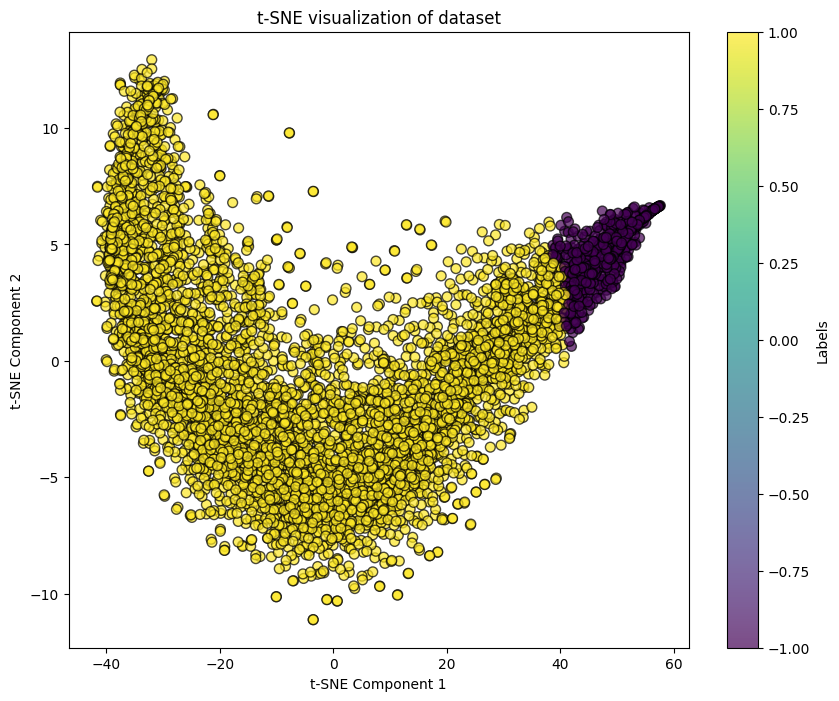

In [216]:
# Create a t-SNE instance and fit_transform the data
tsne = TSNE(n_components=2, random_state=42, perplexity=100, n_iter=3000)
# X_tsne = tsne.fit_transform(df_simil_in.drop(columns=['Provider', 'Is_admit', 'ClmAdmitDiagnosisCode', 'DiagnosisGroupCode',
#        'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
#        'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
#        'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
#        'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
#        'ClmProcedureCode_3']))

X_tsne = tsne.fit_transform(X)
print(tsne.kl_divergence_)

# Plotting the t-SNE result
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],c=y,cmap='viridis', alpha=0.7, edgecolors='k', s=50)

# Add legend and title
plt.title('t-SNE visualization of dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Labels')

plt.show()

In [18]:
data['Anomaly_ind'] = data['Anomaly_score'].apply(lambda x: 1 if x <= -0.1 else 0)
scaled_data_level1['Anomaly_ind'] = scaled_data_level1['Anomaly_score'].apply(lambda x: 1 if x <=-0.1 else 0)

In [19]:
dataset_anom=data[data.Anomaly_ind==1]
dataset_normal=data[data.Anomaly_ind==0]
dataset_anom_scale=scaled_data_level1[scaled_data_level1.Anomaly_ind==1]
dataset_normal_scale=scaled_data_level1[scaled_data_level1.Anomaly_ind==0]

In [20]:
dataset_anom

,79678,71656,64881,36401,V4569,2948,4019,2989,78054,2875,...,0998,80606,79679,00321,80199,9792,9671,90182,Anomaly_ind,Anomaly_score
0,382.053826,172.214110,21.383652,23.564795,221.789201,1387.262504,1512.663932,939.084027,202.946811,1039.868309,...,7.708281,0.990780,3.710063,0.977726,7.708281,2.862957,0.599884,4.170909,1,-0.286940
1,150.450894,64.153763,19.194343,9.167473,86.993771,550.145235,588.686379,368.239366,79.184233,409.578373,...,2.961209,0.369764,1.649175,0.373662,2.961209,1.128197,0.249553,1.546285,1,-0.145500
2,338.357048,146.452917,18.464679,40.720930,207.228355,1238.593299,1376.609599,829.875763,182.616716,913.652464,...,6.827512,1.005052,3.629163,0.869968,6.827512,2.520505,0.622017,3.388450,1,-0.275122
6,169.142330,71.845110,9.140180,9.499516,97.767024,686.706150,719.111205,458.446115,88.911026,518.123173,...,3.005531,0.424350,1.582150,0.385531,3.005531,1.271579,0.273878,2.233105,1,-0.166526
14,724.954209,307.986602,39.975612,45.345391,419.669877,2712.275267,2979.424337,1805.105269,383.766124,2006.643791,...,14.328557,2.263191,7.753936,1.720862,14.328557,5.476015,1.245793,7.593385,1,-0.325694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1620,159.972893,75.440286,8.747675,9.816800,93.885930,584.432266,638.807433,394.777948,85.971436,435.762956,...,2.979422,0.427113,1.540874,0.374633,2.979422,1.258220,0.307582,1.573731,1,-0.157239
1676,119.335918,50.989412,6.461875,6.716989,69.546275,498.330126,516.572515,329.932944,62.161591,379.920542,...,1.950564,0.295907,1.126239,0.261304,1.950564,0.919250,0.159182,1.469515,1,-0.107673
1755,118.720964,50.132516,6.170495,5.893107,67.122940,530.537345,538.088153,351.982499,60.752442,408.675869,...,1.727962,0.304515,1.020368,0.210628,1.727962,0.919492,0.166870,1.389424,1,-0.106538
1987,119.680221,51.509640,6.496123,7.799582,70.195504,426.478751,463.716585,291.996596,64.363257,320.318736,...,2.237847,0.295842,1.214712,0.351088,2.237847,0.901915,0.218507,1.349370,1,-0.109765


In [21]:
clusters=scaled_data_level1['Anomaly_ind'].values

In [22]:
from sklearn.metrics import silhouette_score

score = silhouette_score(scaled_data_level1, clusters)
print(f'Silhouette Score: {score}')

Silhouette Score: 0.8838738528678517


In [23]:
dataset_anom_rank_if_sorted=dataset_anom.sort_values(by='Anomaly_score',ascending=True)


In [24]:
dataset_anom_rank_if_sorted['Rank']=range(1,len(dataset_anom_rank_if_sorted)+1)

In [224]:
dataset_anom_rank_if_sorted

,79678,71656,64881,36401,V4569,2948,4019,2989,78054,2875,...,9671,90182,Provider,Anomaly_ind,Anomaly_score,Anomaly_lof,Anomaly_score_lof,Anomaly_score_rrcf,Anomaly_rrcf,Rank
21,1588.29,677.55,60.29,78.36,947.15,5707.85,6301.70,3847.22,865.37,4220.04,...,0.11,5.34,PRV51459,1,-0.335365,1,-69.355958,207.855844,1,1
16,899.45,386.56,34.84,45.54,528.52,3209.89,3564.69,2166.82,481.21,2378.67,...,0.20,3.43,PRV53797,1,-0.329525,1,-39.252925,117.111111,1,2
49,864.83,384.36,33.27,42.40,506.36,3118.29,3463.38,2102.74,476.09,2308.98,...,0.15,3.04,PRV51574,1,-0.328747,1,-36.809308,204.633333,1,3
14,724.54,306.40,26.96,34.22,419.78,2712.56,2980.57,1804.39,383.38,2008.28,...,0.07,2.35,PRV55215,1,-0.324526,1,-30.934250,163.893333,1,4
352,673.52,290.41,62.95,33.27,411.08,2438.53,2685.99,1642.27,377.63,1806.73,...,0.06,2.65,PRV53918,1,-0.323810,1,-29.746856,167.228571,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,115.51,48.38,3.17,3.32,65.11,530.37,559.91,340.38,58.75,400.24,...,0.05,0.44,PRV54765,1,-0.101868,1,-4.136493,13.638316,0,187
1073,116.98,49.15,9.48,3.54,66.33,527.22,549.25,341.52,59.63,400.80,...,0.02,0.27,PRV51940,1,-0.101555,1,-4.555558,80.939628,1,188
655,111.35,52.72,4.19,5.48,65.80,402.81,432.50,274.08,60.65,301.06,...,0.00,0.45,PRV53773,1,-0.101371,1,-4.614349,30.192125,1,189
62,110.46,52.44,4.57,6.15,66.28,384.69,409.50,266.79,63.78,289.35,...,0.01,0.43,PRV55163,1,-0.101041,1,-4.526572,16.756445,0,190


In [25]:
data_if_rank=util.pickle_dump(dataset_anom_rank_if_sorted,config_data['raw_dataset_path_if_rank'])

In [26]:
Model_pickled=util.pickle_dump(model,config_data['Isolation_forest_model'])

In [47]:
import shap
explainer=shap.TreeExplainer(model)
shap_values=explainer(dataset_anom.drop(['Provider'],axis=1))
#shap_values_norm=explainer(dataset_normal.drop(columns='Provider'))

In [199]:
#PRV55158
df_simil_in[df_simil_in.Provider=='PRV55158']

,Provider,Is_admit,ClmAdmitDiagnosisCode,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3
2,PRV55158,0,64880,NaN,64881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,PRV55158,0,V573,NaN,31400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,PRV55158,0,NaN,NaN,79029,2724,78702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1580,PRV55158,0,NaN,NaN,72293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3017,PRV55158,0,73620,NaN,73811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554182,PRV55158,0,NaN,NaN,42781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
554183,PRV55158,0,NaN,NaN,4271,V5861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
556548,PRV55158,0,9597,NaN,9132,9160,7823,92401,2948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
556743,PRV55158,0,NaN,NaN,82011,V1254,25000,78079,V4364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
data

,79678,71656,64881,36401,V4569,2948,4019,2989,78054,2875,...,0998,80606,79679,00321,80199,9792,9671,90182,Anomaly_ind,Anomaly_score
0,382.053826,172.214110,21.383652,23.564795,221.789201,1387.262504,1512.663932,939.084027,202.946811,1039.868309,...,7.708281,0.990780,3.710063,0.977726,7.708281,2.862957,0.599884,4.170909,1,-0.286940
1,150.450894,64.153763,19.194343,9.167473,86.993771,550.145235,588.686379,368.239366,79.184233,409.578373,...,2.961209,0.369764,1.649175,0.373662,2.961209,1.128197,0.249553,1.546285,1,-0.145500
2,338.357048,146.452917,18.464679,40.720930,207.228355,1238.593299,1376.609599,829.875763,182.616716,913.652464,...,6.827512,1.005052,3.629163,0.869968,6.827512,2.520505,0.622017,3.388450,1,-0.275122
3,17.375588,7.594035,1.058915,1.185392,10.081575,64.914409,72.200386,44.266219,11.106241,49.057951,...,0.440886,0.037283,0.187497,0.032911,0.440886,0.101709,0.023467,0.228908,0,0.085255
4,45.664817,19.714518,2.796142,3.089733,27.226494,172.468880,194.701221,113.086921,24.964456,124.423788,...,1.143212,0.140436,0.490642,0.101812,1.143212,0.468957,0.085140,0.468897,0,0.007084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,0.627936,0.261944,0.048410,0.031430,0.369873,2.272703,2.000357,1.652041,0.312261,1.781987,...,0.005035,0.000828,0.005035,0.000502,0.005035,0.004321,0.000326,0.002506,0,0.132376
5406,0.612834,0.232489,0.024579,0.022527,0.323073,3.331832,2.866803,2.146315,0.277315,2.693896,...,0.006985,0.001089,0.003704,0.000000,0.006985,0.003848,0.000672,0.008177,0,0.131431
5407,1.604162,0.707143,0.075536,0.077759,0.969833,4.830000,4.574458,3.497868,0.828777,3.718378,...,0.020013,0.005743,0.029949,0.013641,0.020013,0.008743,0.001398,0.008163,0,0.139200
5408,0.037810,0.013052,0.001088,0.001305,0.039627,0.406460,1.002828,0.159347,0.017181,0.201499,...,0.000218,0.000218,0.000218,0.000218,0.000218,0.000218,0.000218,0.000218,0,0.085769


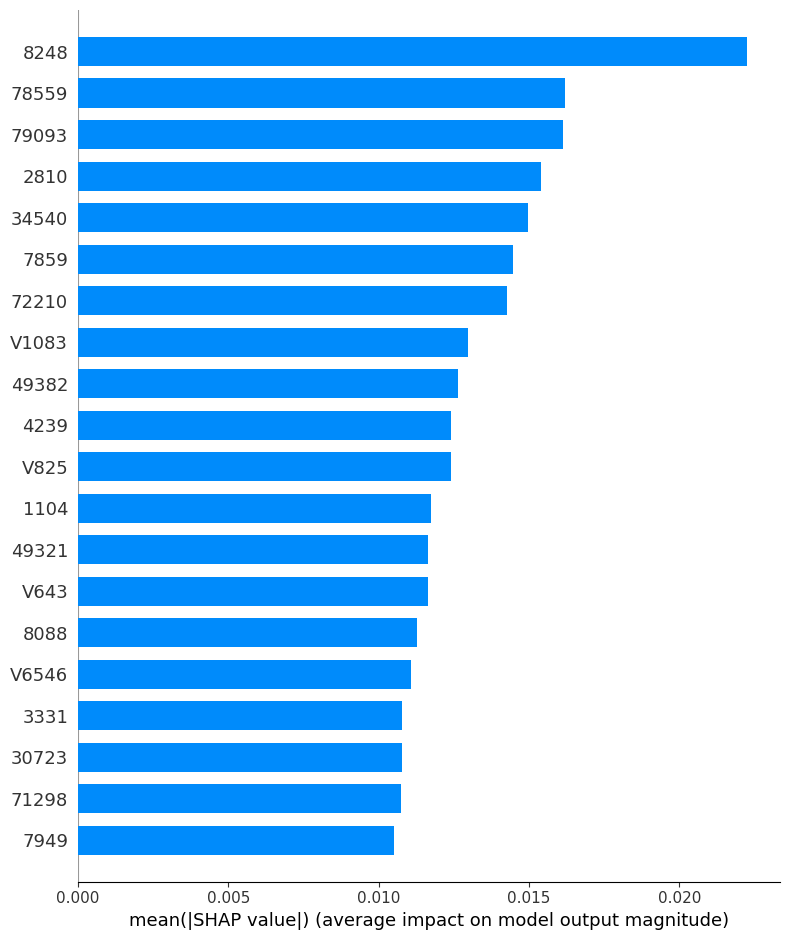

In [202]:
shap.summary_plot(shap_values, plot_type='bar')

In [141]:
type(shap_values[0])

shap._explanation.Explanation

In [142]:
values=shap_values[0].values
feature_importance = pd.DataFrame(list(zip(dataset_anom.columns,values)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=True,inplace=True)
feature_importance

,col_name,feature_importance_vals
1579,79093,-0.019346
316,34540,-0.018014
6197,8248,-0.017057
5349,78559,-0.016164
9608,80470,-0.015656
...,...,...
123,36646,0.000492
3871,71652,0.000500
8375,8785,0.000533
8566,62922,0.000602


In [173]:
data

,79678,71656,64881,36401,V4569,2948,4019,2989,78054,2875,...,80606,79679,00321,80199,9792,9671,90182,Provider,Anomaly_ind,Anomaly_score
0,381.88,171.87,14.75,17.89,222.07,1387.26,1513.14,938.92,202.70,1040.81,...,0.13,1.08,0.20,3.73,0.70,0.02,1.36,PRV57172,1,-0.288957
1,150.23,63.56,16.95,6.89,87.10,550.27,588.94,367.90,79.07,409.75,...,0.03,0.60,0.09,1.49,0.24,0.02,0.52,PRV55158,1,-0.162099
2,338.14,145.45,12.33,36.06,207.20,1238.68,1377.39,829.84,182.48,914.26,...,0.24,1.28,0.18,3.53,0.69,0.07,1.04,PRV54966,1,-0.282564
3,17.33,7.57,0.76,0.97,10.10,64.85,72.26,44.22,11.10,49.14,...,0.01,0.04,0.00,0.26,0.00,0.00,0.12,PRV54890,0,0.086005
4,45.54,19.64,1.96,2.33,27.12,172.47,194.85,113.03,24.87,124.57,...,0.02,0.18,0.02,0.74,0.21,0.01,0.17,PRV52145,0,0.007666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,0.64,0.26,0.03,0.01,0.36,2.27,2.01,1.64,0.32,1.79,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,PRV54294,0,0.128790
5406,0.62,0.22,0.01,0.00,0.32,3.32,2.88,2.15,0.27,2.70,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,PRV51053,0,0.127439
5407,1.60,0.71,0.04,0.06,0.97,4.83,4.57,3.47,0.83,3.72,...,0.00,0.02,0.01,0.00,0.00,0.00,0.00,PRV55405,0,0.134824
5408,0.04,0.01,0.00,0.00,0.04,0.40,1.00,0.16,0.02,0.20,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,PRV57061,0,0.100066


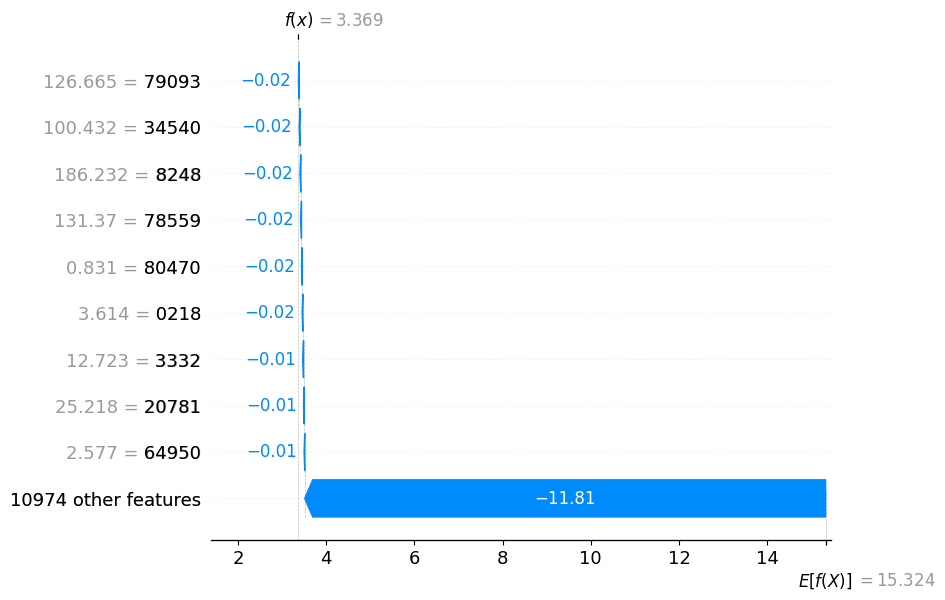

In [206]:
shap.plots.waterfall(shap_values[0])

In [28]:
scaled_data_level1

,79678,71656,64881,36401,V4569,2948,4019,2989,78054,2875,...,0998,80606,79679,00321,80199,9792,9671,90182,Anomaly_ind,Anomaly_score
0,21.490073,22.506592,21.828480,21.615615,21.401150,20.437502,20.408903,20.819299,21.309517,20.655414,...,21.880765,19.716479,19.579048,21.504866,21.880765,20.149302,18.827557,20.899187,1,-0.286940
1,8.214687,8.128384,19.552015,8.160069,8.145979,7.860477,7.694414,7.914201,8.066857,7.887894,...,8.165444,7.113215,8.486778,7.992253,8.165444,7.702776,7.612409,7.507296,1,-0.145500
2,18.985391,19.078880,18.793304,37.649509,19.969302,18.203865,18.536714,18.350426,19.134187,18.098713,...,19.336031,20.006121,19.143621,19.094375,19.336031,17.692282,19.536115,16.906764,1,-0.275122
3,0.586865,0.602705,0.694626,0.700123,0.582783,0.570268,0.587255,0.590133,0.782476,0.584983,...,0.883685,0.365655,0.619619,0.369798,0.883685,0.337942,0.374709,0.785507,0,0.085255
4,2.208392,2.215423,2.501011,2.479895,2.268736,2.186189,2.272940,2.145964,2.265312,2.111637,...,2.912856,2.459109,2.251232,1.911095,2.912856,2.972867,2.349042,2.010026,0,0.007084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,-0.373104,-0.372883,-0.356106,-0.378355,-0.372222,-0.370874,-0.378740,-0.373247,-0.372485,-0.372667,...,-0.375585,-0.374176,-0.362443,-0.355165,-0.375585,-0.360791,-0.366101,-0.369688,0,0.132376
5406,-0.373969,-0.376802,-0.380886,-0.386675,-0.376824,-0.354962,-0.366817,-0.362073,-0.376224,-0.354194,...,-0.369951,-0.368874,-0.369607,-0.366395,-0.369951,-0.364186,-0.355032,-0.340757,0,0.131431
5407,-0.317147,-0.313646,-0.327901,-0.335056,-0.313225,-0.332453,-0.343319,-0.331518,-0.317218,-0.333442,...,-0.332310,-0.274416,-0.228347,-0.061262,-0.332310,-0.329065,-0.331789,-0.340828,0,0.139200
5408,-0.406930,-0.405999,-0.405313,-0.406509,-0.404697,-0.398913,-0.392467,-0.406992,-0.404059,-0.404682,...,-0.389503,-0.386562,-0.388371,-0.361529,-0.389503,-0.390236,-0.369568,-0.381366,0,0.085769


#Local outlier Factor

In [29]:
from sklearn.neighbors import LocalOutlierFactor

# Fit LOF
lof = LocalOutlierFactor(n_neighbors=1000,contamination=0.1)
anomalies = lof.fit_predict(scaled_data_level1.iloc[:, 0:10981])
lof_scores = lof.negative_outlier_factor_  
lof_scores = lof_scores.reshape(-1, 1)  # Reshape for compatibility

# Identify anomalies (Anomalies labeled as -1)
scaled_data_level1['Anomaly_lof']=anomalies
data['Anomaly_lof']=anomalies
scaled_data_level1['Anomaly_score_lof']=lof_scores
data['Anomaly_score_lof']=lof_scores

/Users/Geethika/Documents/GitHub/Medicare Claims/.venv/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [30]:
scaled_data_level1['Anomaly_lof'].value_counts()

Anomaly_lof
 1    4869
-1     541
Name: count, dtype: int64

In [31]:
data

,79678,71656,64881,36401,V4569,2948,4019,2989,78054,2875,...,79679,00321,80199,9792,9671,90182,Anomaly_ind,Anomaly_score,Anomaly_lof,Anomaly_score_lof
0,382.053826,172.214110,21.383652,23.564795,221.789201,1387.262504,1512.663932,939.084027,202.946811,1039.868309,...,3.710063,0.977726,7.708281,2.862957,0.599884,4.170909,1,-0.286940,-1,-10.433183
1,150.450894,64.153763,19.194343,9.167473,86.993771,550.145235,588.686379,368.239366,79.184233,409.578373,...,1.649175,0.373662,2.961209,1.128197,0.249553,1.546285,1,-0.145500,-1,-3.874496
2,338.357048,146.452917,18.464679,40.720930,207.228355,1238.593299,1376.609599,829.875763,182.616716,913.652464,...,3.629163,0.869968,6.827512,2.520505,0.622017,3.388450,1,-0.275122,-1,-9.292076
3,17.375588,7.594035,1.058915,1.185392,10.081575,64.914409,72.200386,44.266219,11.106241,49.057951,...,0.187497,0.032911,0.440886,0.101709,0.023467,0.228908,0,0.085255,1,-1.463522
4,45.664817,19.714518,2.796142,3.089733,27.226494,172.468880,194.701221,113.086921,24.964456,124.423788,...,0.490642,0.101812,1.143212,0.468957,0.085140,0.468897,0,0.007084,1,-1.596721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,0.627936,0.261944,0.048410,0.031430,0.369873,2.272703,2.000357,1.652041,0.312261,1.781987,...,0.005035,0.000502,0.005035,0.004321,0.000326,0.002506,0,0.132376,1,-0.999788
5406,0.612834,0.232489,0.024579,0.022527,0.323073,3.331832,2.866803,2.146315,0.277315,2.693896,...,0.003704,0.000000,0.006985,0.003848,0.000672,0.008177,0,0.131431,1,-0.999631
5407,1.604162,0.707143,0.075536,0.077759,0.969833,4.830000,4.574458,3.497868,0.828777,3.718378,...,0.029949,0.013641,0.020013,0.008743,0.001398,0.008163,0,0.139200,1,-0.972254
5408,0.037810,0.013052,0.001088,0.001305,0.039627,0.406460,1.002828,0.159347,0.017181,0.201499,...,0.000218,0.000218,0.000218,0.000218,0.000218,0.000218,0,0.085769,1,-1.060430


In [32]:
scaled_data_level1['Anomaly_lof'] = scaled_data_level1['Anomaly_lof'].apply(lambda x: 1 if x == -1 else 0)
data['Anomaly_lof'] = data['Anomaly_lof'].apply(lambda x: 1 if x ==-1 else 0)

In [231]:
X=scaled_data_level1.drop(columns=['Anomaly_lof','Anomaly_ind','Anomaly_score','Anomaly_lof'])
y=scaled_data_level1['Anomaly_lof']

/Users/Geethika/Documents/GitHub/Medicare Claims/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


1.1186527013778687


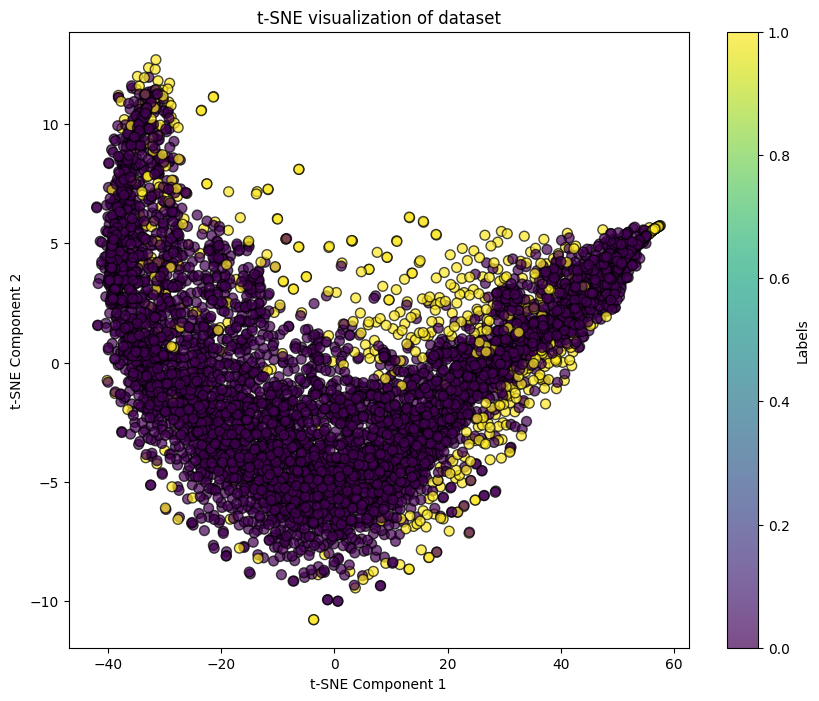

In [232]:
from sklearn.manifold import TSNE
# Create a t-SNE instance and fit_transform the data
tsne = TSNE(n_components=2, random_state=42, perplexity=100, n_iter=3000)
X_tsne = tsne.fit_transform(X)
print(tsne.kl_divergence_)

# Plotting the t-SNE result
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],c=y,cmap='viridis', alpha=0.7, edgecolors='k', s=50)

# Add legend and title
plt.title('t-SNE visualization of dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Labels')

plt.show()

In [33]:
dataset_anom_lof=data[data.Anomaly_lof==1]
dataset_normal_lof=data[data.Anomaly_lof==0]
dataset_anom_scale_lof=scaled_data_level1[scaled_data_level1.Anomaly_lof==1]
dataset_normal_scale_lof=scaled_data_level1[scaled_data_level1.Anomaly_lof==0]

In [34]:
dataset_anom_lof

,79678,71656,64881,36401,V4569,2948,4019,2989,78054,2875,...,79679,00321,80199,9792,9671,90182,Anomaly_ind,Anomaly_score,Anomaly_lof,Anomaly_score_lof
0,382.053826,172.214110,21.383652,23.564795,221.789201,1387.262504,1512.663932,939.084027,202.946811,1039.868309,...,3.710063,0.977726,7.708281,2.862957,0.599884,4.170909,1,-0.286940,1,-10.433183
1,150.450894,64.153763,19.194343,9.167473,86.993771,550.145235,588.686379,368.239366,79.184233,409.578373,...,1.649175,0.373662,2.961209,1.128197,0.249553,1.546285,1,-0.145500,1,-3.874496
2,338.357048,146.452917,18.464679,40.720930,207.228355,1238.593299,1376.609599,829.875763,182.616716,913.652464,...,3.629163,0.869968,6.827512,2.520505,0.622017,3.388450,1,-0.275122,1,-9.292076
5,89.223534,38.736900,5.041953,5.715376,52.334475,318.614267,347.740392,217.103709,48.348684,236.667145,...,0.831026,0.236157,1.761424,0.691180,0.148636,0.906994,0,-0.063315,1,-2.423121
6,169.142330,71.845110,9.140180,9.499516,97.767024,686.706150,719.111205,458.446115,88.911026,518.123173,...,1.582150,0.385531,3.005531,1.271579,0.273878,2.233105,1,-0.166526,1,-4.345005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,0.341197,0.202529,0.003430,0.023549,0.241038,1.064010,1.194638,0.667358,0.212054,0.735619,...,0.019300,0.000782,0.021481,0.000782,0.000304,0.000782,0,0.120888,1,-82.352131
5029,1.628883,0.655936,0.079018,0.119870,0.936761,8.662904,11.834457,4.894937,0.830903,5.594936,...,0.016762,0.006686,0.050495,0.007920,0.002077,0.014316,0,0.137832,1,-11.236104
5124,3.330647,1.419045,0.201900,0.161782,1.872844,16.468850,18.354850,9.804411,1.721960,11.654518,...,0.017342,0.004697,0.042400,0.031556,0.003497,0.040904,0,0.139020,1,-2.263068
5175,0.137275,0.051142,0.003623,0.004348,0.092909,0.848728,1.427049,0.427993,0.078856,0.503129,...,0.000725,0.000218,0.000725,0.000725,0.000218,0.000725,0,0.102241,1,-2.395491


In [35]:
from sklearn.metrics import silhouette_score
clusters=scaled_data_level1['Anomaly_lof'].values
score = silhouette_score(scaled_data_level1, clusters)
print(f'Silhouette Score: {score}')

Silhouette Score: 0.7536284560740922


In [36]:
Lof_model_pickled=util.pickle_dump(model,config_data['Lof_model'])

#SHAP

In [88]:
dataset_anom_lof

Value,79678,71656,64881,36401,2948,31400,42490,11590,72089,4271,...,90241,0828,E8262,E9192,86131,Provider,Anomaly_ind,Anomaly_score,Anomaly_lof,Anomaly_score_lof
0,170.222639,233.793277,166.550720,172.413360,593.038796,199.774255,271.861925,170.367414,173.808939,453.939261,...,0.0,0.0,0.000000,0.0,0.000000,PRV57172,1,-0.262225,1,-1.782709e+00
2,202.980515,280.293728,198.915288,205.897731,617.579704,223.168197,260.235973,204.225595,207.235427,390.714750,...,0.0,0.0,0.000000,0.0,0.000000,PRV54966,1,-0.255667,1,-1.689227e+00
10,14.221072,26.955897,13.941218,14.378316,161.939616,27.474631,57.368350,14.005945,14.344323,134.139478,...,0.0,1.0,0.000000,0.0,0.000000,PRV54894,0,-0.073665,1,-1.276923e+00
14,396.500788,525.501688,387.600651,401.886443,1286.243391,446.566754,556.297167,392.308985,401.717031,918.471395,...,0.0,0.0,0.880158,0.0,0.933709,PRV55215,1,-0.316575,1,-3.751082e+00
15,2.737950,2.656285,2.654993,2.709501,8.906449,3.577181,5.385284,2.661467,2.714942,8.177066,...,0.0,0.0,0.000000,0.0,0.000000,PRV54950,0,0.138954,1,-1.558984e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5337,0.000000,0.885863,0.000000,0.000000,1.780163,0.000000,0.000000,0.000000,0.000000,0.878099,...,0.0,0.0,0.000000,0.0,0.000000,PRV53601,0,0.193582,1,-2.072193e+11
5358,0.000000,0.000000,0.000000,0.000000,2.668310,0.891043,3.531970,0.000000,0.000000,3.551500,...,0.0,0.0,0.000000,0.0,0.000000,PRV53336,0,0.183276,1,-2.791395e+11
5379,0.000000,0.000000,0.000000,0.000000,1.872760,0.000000,0.000000,0.000000,0.000000,0.913582,...,0.0,0.0,0.000000,0.0,0.000000,PRV54503,0,0.198895,1,-1.552877e+11
5392,0.908907,0.875098,0.884265,0.934297,1.710453,0.900916,0.909356,0.888574,0.916258,4.557457,...,0.0,0.0,0.000000,0.0,0.000000,PRV57093,0,0.198236,1,-1.688991e+11


In [236]:
dataset_anom_lof

,79678,71656,64881,36401,V4569,2948,4019,2989,78054,2875,...,9792,9671,90182,Provider,Anomaly_ind,Anomaly_score,Anomaly_lof,Anomaly_score_lof,Anomaly_score_rrcf,Anomaly_rrcf
0,381.88,171.87,14.75,17.89,222.07,1387.26,1513.14,938.92,202.70,1040.81,...,0.70,0.02,1.36,PRV57172,1,-0.280880,1,-3.266401,46.106550,1
2,338.14,145.45,12.33,36.06,207.20,1238.68,1377.39,829.84,182.48,914.26,...,0.69,0.07,1.04,PRV54966,1,-0.269979,1,-2.966082,88.019444,1
3,17.33,7.57,0.76,0.97,10.10,64.85,72.26,44.22,11.10,49.14,...,0.00,0.00,0.12,PRV54890,0,0.091992,1,-4.831318,6.000229,0
8,9.82,4.07,0.43,0.43,5.83,37.25,44.75,24.19,5.24,26.95,...,0.02,0.08,0.03,PRV55104,0,0.120464,1,-8.305518,18.117755,0
14,724.54,306.40,26.96,34.22,419.78,2712.56,2980.57,1804.39,383.38,2008.28,...,1.26,0.07,2.35,PRV55215,1,-0.324526,1,-7.109778,163.893333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5233,1.07,0.57,0.07,0.10,0.68,2.71,2.99,2.04,0.60,2.14,...,0.00,0.00,0.00,PRV54862,0,0.135105,1,-4.187340,4.222446,0
5266,0.16,0.06,0.01,0.01,0.09,0.57,0.87,0.32,0.08,0.37,...,0.00,0.00,0.00,PRV52753,0,0.119423,1,-3.345630,8.434000,0
5289,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.02,0.01,...,0.00,0.00,0.00,PRV52261,0,0.105733,1,-2.676812,13.210833,0
5312,0.51,0.22,0.01,0.01,0.28,2.85,3.48,1.55,0.23,1.87,...,0.00,0.00,0.00,PRV57143,0,0.136277,1,-5.022104,13.030952,0


In [237]:
scaled_data_level1

,79678,71656,64881,36401,V4569,2948,4019,2989,78054,2875,...,80199,9792,9671,90182,Anomaly_ind,Anomaly_score,Anomaly_lof,Anomaly_score_lof,Anomaly_score_rrcf,Anomaly_rrcf
0,21.457486,22.539386,22.292308,21.9750,21.274103,20.413972,20.414669,20.818608,21.365199,20.656884,...,21.588235,17.25,0.02,19.142857,1,-0.280880,1,-3.266401,46.106550,1
1,8.193816,8.078772,25.676923,8.2250,8.096656,7.853155,7.697341,7.907637,8.085929,7.884329,...,8.411765,5.75,0.02,7.142857,1,-0.147405,0,-1.507695,42.243057,1
2,18.953049,19.012016,18.569231,44.6875,19.822309,18.184213,18.546699,18.352270,19.193340,18.095532,...,20.411765,17.00,0.07,14.571429,1,-0.269979,1,-2.966082,88.019444,1
3,0.584311,0.603471,0.769231,0.8250,0.578960,0.568395,0.587636,0.589113,0.785177,0.585640,...,1.176471,-0.25,0.00,1.428571,0,0.091992,1,-4.831318,6.000229,0
4,2.199542,2.214953,2.615385,2.5250,2.240664,2.183462,2.274519,2.144932,2.264232,2.112331,...,4.000000,5.00,0.01,2.142857,0,0.005241,0,-1.268091,12.836499,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,-0.371314,-0.372497,-0.353846,-0.3750,-0.371979,-0.370751,-0.379029,-0.373636,-0.372718,-0.372717,...,-0.352941,-0.25,0.00,-0.285714,0,0.137891,0,-1.218478,4.925882,0
5406,-0.372459,-0.377837,-0.384615,-0.3875,-0.375885,-0.354994,-0.367058,-0.362105,-0.378088,-0.354298,...,-0.352941,-0.25,0.00,-0.285714,0,0.136803,0,-0.990905,3.493170,0
5407,-0.316347,-0.312417,-0.338462,-0.3125,-0.312424,-0.332333,-0.343803,-0.332259,-0.317938,-0.333654,...,-0.352941,-0.25,0.00,-0.285714,0,0.143892,0,-1.584886,9.765333,0
5408,-0.405668,-0.405874,-0.400000,-0.3875,-0.403222,-0.398814,-0.392927,-0.407100,-0.404941,-0.404898,...,-0.352941,-0.25,0.00,-0.285714,0,0.105964,0,-2.343408,6.583016,0


In [238]:
dataset_anom_lof['Anomaly_score_lof'].max()

-2.3767494933505615

In [239]:
dataset_anom_lof

,79678,71656,64881,36401,V4569,2948,4019,2989,78054,2875,...,9792,9671,90182,Provider,Anomaly_ind,Anomaly_score,Anomaly_lof,Anomaly_score_lof,Anomaly_score_rrcf,Anomaly_rrcf
0,381.88,171.87,14.75,17.89,222.07,1387.26,1513.14,938.92,202.70,1040.81,...,0.70,0.02,1.36,PRV57172,1,-0.280880,1,-3.266401,46.106550,1
2,338.14,145.45,12.33,36.06,207.20,1238.68,1377.39,829.84,182.48,914.26,...,0.69,0.07,1.04,PRV54966,1,-0.269979,1,-2.966082,88.019444,1
3,17.33,7.57,0.76,0.97,10.10,64.85,72.26,44.22,11.10,49.14,...,0.00,0.00,0.12,PRV54890,0,0.091992,1,-4.831318,6.000229,0
8,9.82,4.07,0.43,0.43,5.83,37.25,44.75,24.19,5.24,26.95,...,0.02,0.08,0.03,PRV55104,0,0.120464,1,-8.305518,18.117755,0
14,724.54,306.40,26.96,34.22,419.78,2712.56,2980.57,1804.39,383.38,2008.28,...,1.26,0.07,2.35,PRV55215,1,-0.324526,1,-7.109778,163.893333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5233,1.07,0.57,0.07,0.10,0.68,2.71,2.99,2.04,0.60,2.14,...,0.00,0.00,0.00,PRV54862,0,0.135105,1,-4.187340,4.222446,0
5266,0.16,0.06,0.01,0.01,0.09,0.57,0.87,0.32,0.08,0.37,...,0.00,0.00,0.00,PRV52753,0,0.119423,1,-3.345630,8.434000,0
5289,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.02,0.01,...,0.00,0.00,0.00,PRV52261,0,0.105733,1,-2.676812,13.210833,0
5312,0.51,0.22,0.01,0.01,0.28,2.85,3.48,1.55,0.23,1.87,...,0.00,0.00,0.00,PRV57143,0,0.136277,1,-5.022104,13.030952,0


100%|===================| 540/541 [00:19<00:00]        

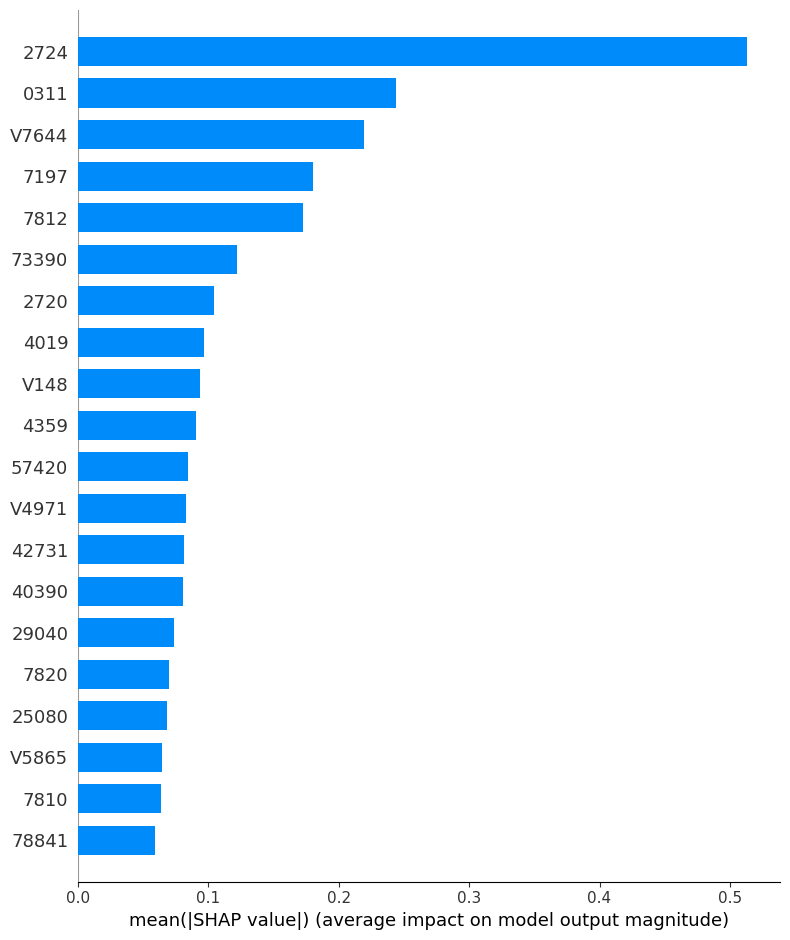

In [133]:
from sklearn.ensemble import RandomForestRegressor
import shap
lof_scores = dataset_anom_lof['Anomaly_score_lof'].values # Invert for easier interpretation


# Fit a Random Forest model on the LOF scores
rf_model = RandomForestRegressor()
rf_model.fit(dataset_anom_lof.drop(columns=['Provider','Anomaly_ind','Anomaly_score','Anomaly_lof','Anomaly_score_lof']), lof_scores)

# Use SHAP to explain the Random Forest model
explainer = shap.TreeExplainer(rf_model, dataset_anom_lof.drop(columns=['Provider','Anomaly_ind','Anomaly_score','Anomaly_lof','Anomaly_score_lof']))
shap_values_lof = explainer(dataset_anom_lof.drop(columns=['Provider','Anomaly_ind','Anomaly_score','Anomaly_lof','Anomaly_score_lof']))

# Visualize SHAP values
shap.summary_plot(shap_values_lof, dataset_anom_lof.drop(columns=['Provider','Anomaly_ind','Anomaly_score','Anomaly_lof','Anomaly_score_lof']),plot_type='bar')

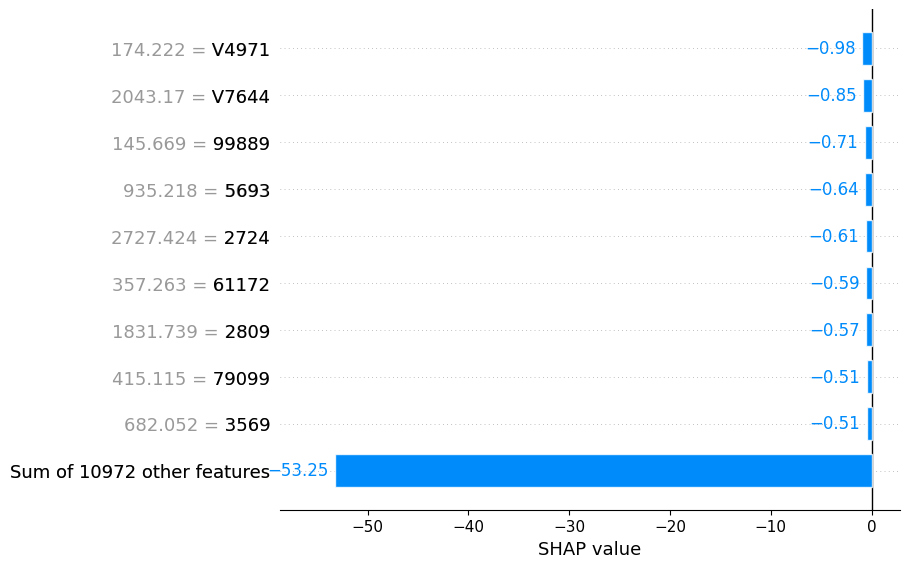

In [134]:
shap.plots.bar(shap_values_lof[8])

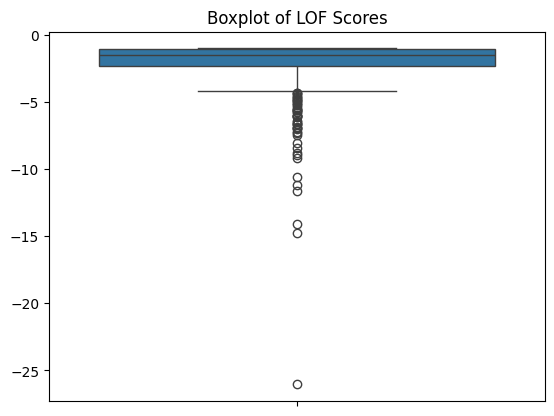

In [165]:
import seaborn as sns

sns.boxplot(y=lof_scores)
plt.title('Boxplot of LOF Scores')
plt.show()

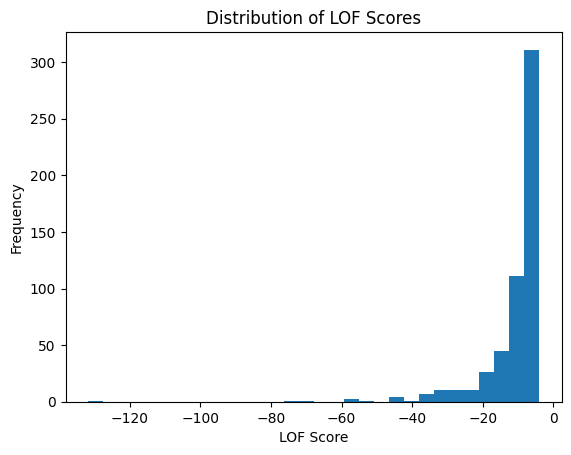

In [135]:
import matplotlib.pyplot as plt

plt.hist(lof_scores, bins=30)
plt.xlabel('LOF Score')
plt.ylabel('Frequency')
plt.title('Distribution of LOF Scores')
plt.show()

In [37]:
dataset_anom_rank_lof_sorted=dataset_anom_lof.sort_values(by='Anomaly_score_lof',ascending=True)

In [38]:
dataset_anom_rank_lof_sorted['Rank']=range(1,len(dataset_anom_rank_lof_sorted)+1)

In [39]:
dataset_anom_rank_lof_sorted

,79678,71656,64881,36401,V4569,2948,4019,2989,78054,2875,...,00321,80199,9792,9671,90182,Anomaly_ind,Anomaly_score,Anomaly_lof,Anomaly_score_lof,Rank
4994,0.341197,0.202529,0.003430,0.023549,0.241038,1.064010,1.194638,0.667358,0.212054,0.735619,...,0.000782,0.021481,0.000782,0.000304,0.000782,0,0.120888,1,-82.352131,1
21,1589.029749,680.496624,87.038817,101.403059,947.166418,5707.035369,6298.354051,3848.838597,868.872211,4215.444481,...,4.276672,32.901508,11.524598,2.625417,16.364909,1,-0.333420,1,-50.534704,2
4698,0.696044,0.344784,0.065165,0.035212,0.488357,2.236464,2.582303,1.462199,0.394529,1.608594,...,0.000592,0.007483,0.003738,0.000592,0.005323,0,0.129546,1,-39.667903,3
5306,0.599972,0.276462,0.026773,0.026518,0.330302,2.208091,2.281648,1.514867,0.272821,1.764662,...,0.000588,0.002074,0.005980,0.000588,0.003067,0,0.132073,1,-39.171147,4
4535,2.147770,1.075865,0.257531,0.169127,1.372713,7.825792,9.801267,5.166999,1.185445,5.686956,...,0.017146,0.052786,0.014646,0.003384,0.017283,0,0.132144,1,-34.235463,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,12.040136,5.061308,0.642742,0.676894,6.950837,45.359169,48.253404,30.783684,6.375550,33.912864,...,0.029176,0.265455,0.081125,0.019088,0.104091,0,0.114312,1,-2.114208,537
867,73.454800,31.988004,4.036775,4.504976,43.385532,268.725328,296.553919,180.672488,40.130319,198.397186,...,0.192451,1.396538,0.505761,0.134813,0.763678,0,-0.046824,1,-2.112931,538
1999,74.653558,31.505002,3.799812,3.837969,42.211990,341.238544,357.000363,220.771539,37.499774,259.253362,...,0.140506,1.148728,0.640670,0.173963,0.855572,0,-0.051409,1,-2.112589,539
2101,75.193121,31.949552,3.970775,3.808959,43.185811,328.060124,339.036197,216.136254,38.483417,250.275211,...,0.126830,1.116004,0.600378,0.130704,0.834084,0,-0.052864,1,-2.110912,540


In [40]:
data_lof_rank=util.pickle_dump(dataset_anom_rank_lof_sorted.drop(columns=['Anomaly_ind','Anomaly_score']),config_data['raw_dataset_path_lof_rank'])

#RRCF

In [41]:
import numpy as np
import pandas as pd
import rrcf

n=5410
# Set forest parameters
num_trees = 200
tree_size = 256
sample_size_range = (n // tree_size, tree_size)

# Construct forest
forest = []
while len(forest) < num_trees:
    # Select random subsets of points uniformly
    ixs = np.random.choice(n, size=sample_size_range,
                           replace=False)
    # Add sampled trees to forest
    trees = [rrcf.RCTree(scaled_data_level1.iloc[ix].values, index_labels=ix)
             for ix in ixs]
    forest.extend(trees)

# Compute average CoDisp
avg_codisp = pd.Series(0.0, index=np.arange(n))
index = np.zeros(n)
for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf)
                       for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)
avg_codisp /= index
scaled_data_level1['Anomaly_score_rrcf'] =avg_codisp
data['Anomaly_score_rrcf']=avg_codisp



<Axes: >

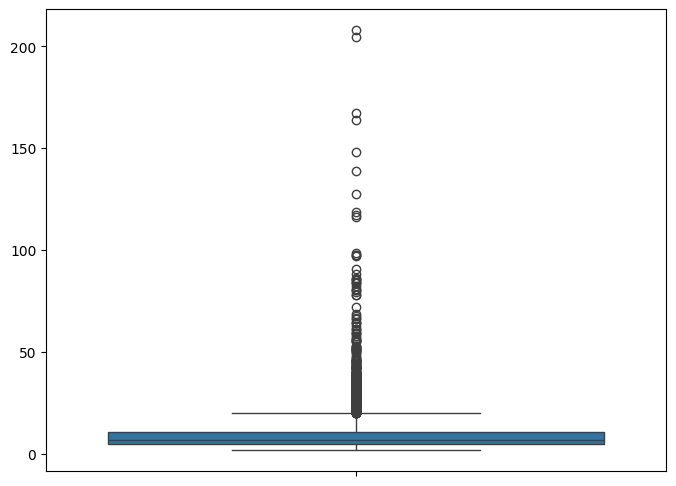

In [193]:
plt.figure(figsize=(8, 6))  # Adjust the figure size
sns.boxplot(data=avg_codisp)

In [43]:
scaled_data_level1['Anomaly_rrcf'] = scaled_data_level1['Anomaly_score_rrcf'].apply(lambda x: 1 if x >= avg_codisp.quantile(0.95) else 0)
data['Anomaly_rrcf'] = data['Anomaly_score_rrcf'].apply(lambda x: 1 if x >= avg_codisp.quantile(0.95) else 0)

In [195]:
X=scaled_data_level1.drop(columns='Anomaly_rrcf')
y=scaled_data_level1['Anomaly_rrcf']

/Users/Geethika/Documents/GitHub/Medicare Claims/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


1.5049911737442017


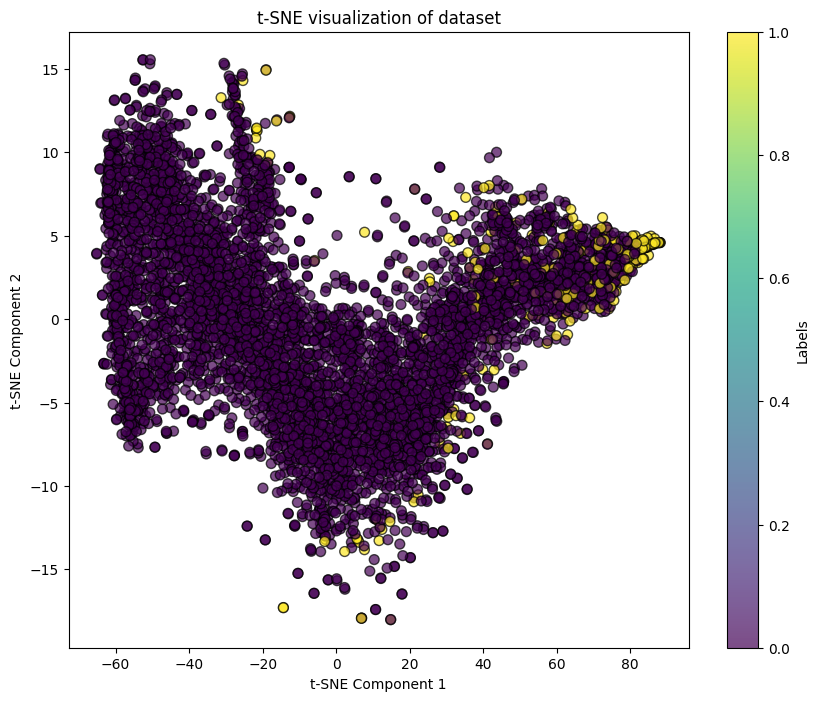

In [196]:
from sklearn.manifold import TSNE
# Create a t-SNE instance and fit_transform the data
tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=3000)
X_tsne = tsne.fit_transform(X)
print(tsne.kl_divergence_)

# Plotting the t-SNE result
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],c=y,cmap='viridis', alpha=0.7, edgecolors='k', s=50)

# Add legend and title
plt.title('t-SNE visualization of dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Labels')

plt.show()

In [44]:
dataset_anom_rrcf=data[data.Anomaly_rrcf==1]
dataset_normal_rrcf=data[data.Anomaly_rrcf==0]
dataset_anom_scale_rrcf=data[scaled_data_level1.Anomaly_rrcf==1]
dataset_normal_scale_rrcf=scaled_data_level1[scaled_data_level1.Anomaly_rrcf==0]

In [45]:
dataset_anom_rrcf.fillna(0,inplace=True)

/var/folders/nd/f34czdrj02175j4j_k03vfyw0000gp/T/ipykernel_13222/4115193019.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_anom_rrcf.fillna(0,inplace=True)


In [201]:
dataset_anom_rrcf

,79678,71656,64881,36401,V4569,2948,4019,2989,78054,2875,...,9792,9671,90182,Provider,Anomaly_ind,Anomaly_score,Anomaly_lof,Anomaly_score_lof,Anomaly_score_rrcf,Anomaly_rrcf
0,381.88,171.87,14.75,17.89,222.07,1387.26,1513.14,938.92,202.70,1040.81,...,0.70,0.02,1.36,PRV57172,1,-0.288957,1,-15.390659,46.106550,1
1,150.23,63.56,16.95,6.89,87.10,550.27,588.94,367.90,79.07,409.75,...,0.24,0.02,0.52,PRV55158,1,-0.162099,1,-6.116445,42.243057,1
2,338.14,145.45,12.33,36.06,207.20,1238.68,1377.39,829.84,182.48,914.26,...,0.69,0.07,1.04,PRV54966,1,-0.282564,1,-14.031917,88.019444,1
14,724.54,306.40,26.96,34.22,419.78,2712.56,2980.57,1804.39,383.38,2008.28,...,1.26,0.07,2.35,PRV55215,1,-0.335624,1,-30.934250,163.893333,1
16,899.45,386.56,34.84,45.54,528.52,3209.89,3564.69,2166.82,481.21,2378.67,...,2.07,0.20,3.43,PRV53797,1,-0.341746,1,-39.252925,117.111111,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4534,1.61,0.74,0.09,0.02,0.92,6.92,7.33,4.53,0.84,5.30,...,0.00,0.00,0.00,PRV56340,0,0.132360,0,-1.109953,35.419767,1
4578,6.51,2.70,0.23,0.25,3.77,22.99,23.66,15.97,3.45,17.39,...,0.03,0.00,0.02,PRV53087,0,0.125455,0,-0.998283,39.007143,1
4716,1.39,0.62,0.04,0.08,0.90,5.92,7.21,3.87,0.78,4.31,...,0.01,0.00,0.01,PRV53741,0,0.136865,0,-1.088760,32.076720,1
4783,3.27,1.56,0.15,0.16,2.07,10.54,11.37,7.78,1.79,8.43,...,0.00,0.00,0.01,PRV54712,0,0.133296,0,-1.150671,34.440476,1


In [46]:
rrcf_model_pickled=util.pickle_dump(model,config_data['rrcf_model'])

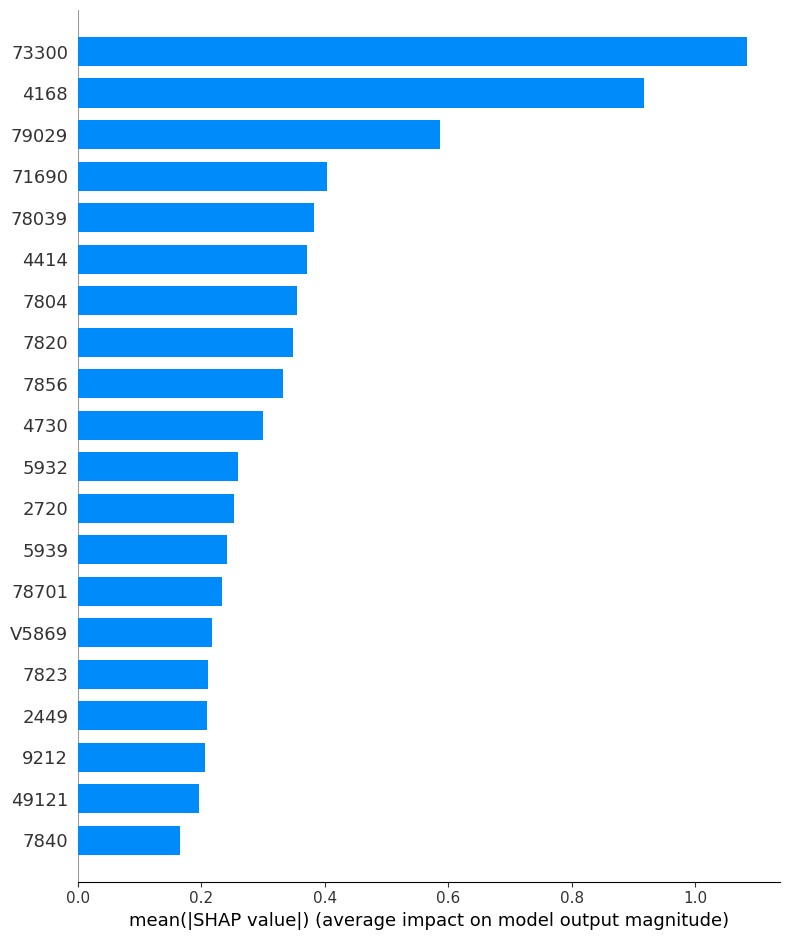

In [156]:
from sklearn.ensemble import RandomForestRegressor
rrcf_scores = dataset_anom_rrcf['Anomaly_score_rrcf'].values # Invert for easier interpretation


# Fit a Random Forest model on the LOF scores
rf_model = RandomForestRegressor()
rf_model.fit(dataset_anom_rrcf.drop(columns=['Provider','Anomaly_ind','Anomaly_score','Anomaly_lof','Anomaly_score_lof','Anomaly_rrcf','Anomaly_score_rrcf']), rrcf_scores)

# Use SHAP to explain the Random Forest model
explainer = shap.Explainer(rf_model, dataset_anom_rrcf.drop(columns=['Provider','Anomaly_ind','Anomaly_score','Anomaly_lof','Anomaly_score_lof','Anomaly_rrcf','Anomaly_score_rrcf']))
shap_values_rrcf = explainer(dataset_anom_rrcf.drop(columns=['Provider','Anomaly_ind','Anomaly_score','Anomaly_lof','Anomaly_score_lof','Anomaly_rrcf','Anomaly_score_rrcf']))


# Visualize SHAP values
shap.summary_plot(shap_values_rrcf, dataset_anom_rrcf.drop(columns=['Provider','Anomaly_ind','Anomaly_score','Anomaly_lof','Anomaly_score_lof','Anomaly_rrcf','Anomaly_score_rrcf']),plot_type='bar')

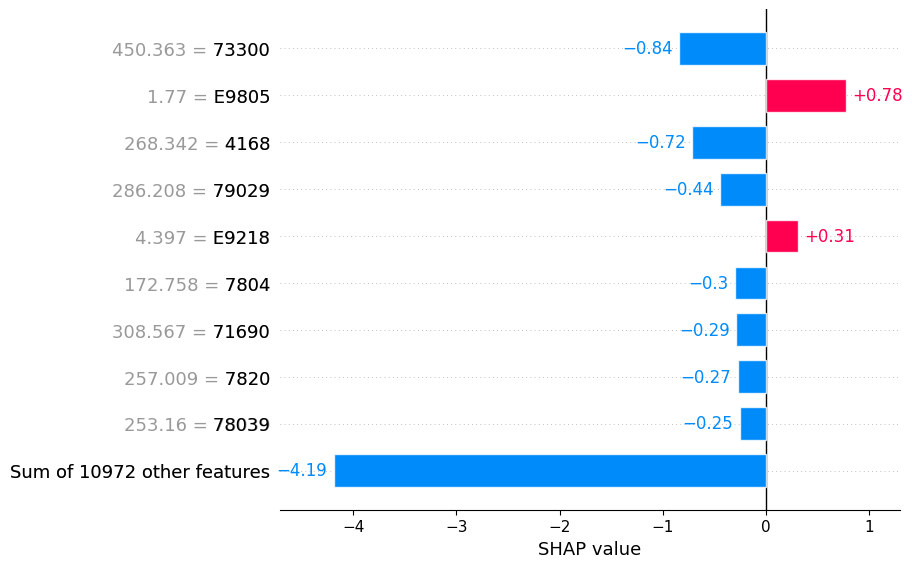

In [157]:
shap.plots.bar(shap_values_rrcf[1])

In [47]:
dataset_anom_rank_rrcf_sorted=dataset_anom_rrcf.sort_values(by='Anomaly_score_rrcf',ascending=False)

In [48]:
dataset_anom_rank_rrcf_sorted['Rank']=range(1,len(dataset_anom_rank_rrcf_sorted)+1)

In [49]:
dataset_anom_rank_rrcf_sorted

,79678,71656,64881,36401,V4569,2948,4019,2989,78054,2875,...,9792,9671,90182,Anomaly_ind,Anomaly_score,Anomaly_lof,Anomaly_score_lof,Anomaly_score_rrcf,Anomaly_rrcf,Rank
16,899.866565,388.711814,49.691866,58.403836,528.345129,3209.133584,3562.696692,2167.539485,482.464324,2376.108605,...,7.167779,1.599572,9.665428,1,-0.329968,1,-27.638912,192.657143,1,1
21,1589.029749,680.496624,87.038817,101.403059,947.166418,5707.035369,6298.354051,3848.838597,868.872211,4215.444481,...,11.524598,2.625417,16.364909,1,-0.333420,1,-50.534704,191.519048,1,2
49,865.945998,385.890232,48.308187,55.300250,505.911784,3117.819269,3461.964802,2103.257240,477.000046,2306.149662,...,6.273741,1.496713,8.850327,1,-0.329100,1,-26.093775,148.333333,1,3
352,674.333495,291.563262,74.402681,43.485690,410.771825,2439.066176,2684.504620,1642.577552,378.487277,1804.695556,...,5.024424,1.151165,7.137709,1,-0.324399,1,-20.407552,142.320000,1,4
105,560.743979,239.870995,29.675026,31.898439,333.786344,2284.279288,2386.079763,1515.200630,293.551342,1726.501846,...,4.373206,0.869956,6.435496,1,-0.316640,1,-16.018385,126.216667,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,233.325125,101.227136,13.298823,15.276332,138.254346,832.508038,901.756012,568.949770,131.945084,621.320088,...,1.927505,0.389581,2.646533,1,-0.222818,1,-6.347748,21.160466,1,267
312,105.032899,45.204605,5.824325,7.172892,62.301463,385.859577,425.995020,261.001716,60.150689,287.999907,...,0.751548,0.167615,1.232748,0,-0.080960,1,-2.870219,21.089070,1,268
1169,93.072113,41.035674,5.215567,5.837772,55.091357,354.639555,393.475941,233.565795,49.845478,262.007220,...,0.784336,0.136354,1.082433,0,-0.067385,1,-2.612238,21.054496,1,269
319,78.315045,33.246123,4.399860,4.900833,44.792351,274.054709,304.648840,183.451261,41.360135,202.860216,...,0.651644,0.126184,0.808644,0,-0.050214,1,-2.229879,21.003630,1,270


In [205]:
data_rrcf_rank=util.pickle_dump(dataset_anom_rank_rrcf_sorted.drop(columns=['Anomaly_ind','Anomaly_score','Anomaly_lof','Anomaly_score_lof'],axis=1),config_data['raw_dataset_path_rrcf_rank'])